# SwinIR: Image Restoration Using Swin Transformer

### Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
!pip install swin-transformer-pytorch
from swin_transformer_pytorch import SwinTransformer

import cv2
import numpy as np
import matplotlib.pyplot as plt

!pip install rawpy
import rawpy
import glob
from collections import defaultdict
import requests
import os
import math

In [2]:
print(torch.__version__)

2.5.1+cu121


## Prepare the Dataset: Sony Low-Light Raw Image Dataset

### Load the Dataset

In [ ]:
long_dataset_path = "/kaggle/input/sid-sony-dataset/Sony/long"
short_dataset_path = "/kaggle/input/sid-sony-dataset/Sony/short"

# get all ARW image paths
long_image_paths = sorted(glob.glob(long_dataset_path + "/*.ARW"))
short_image_paths = sorted(glob.glob(short_dataset_path + "/*.ARW"))

print(len(long_image_paths), len(short_image_paths))

In [5]:
!ls "/kaggle/input/sid-sony-dataset/Sony/long" | head

00001_00_10s.ARW
00002_00_10s.ARW
00004_00_10s.ARW
00009_00_10s.ARW
00010_00_10s.ARW
00012_00_10s.ARW
00013_00_10s.ARW
00014_00_10s.ARW
00015_00_10s.ARW
00017_00_10s.ARW


In [6]:
!ls "/kaggle/input/sid-sony-dataset/Sony/short" | head

00001_00_0.04s.ARW
00001_00_0.1s.ARW
00001_01_0.04s.ARW
00001_01_0.1s.ARW
00001_02_0.1s.ARW
00001_03_0.1s.ARW
00001_04_0.1s.ARW
00001_05_0.1s.ARW
00001_06_0.1s.ARW
00001_07_0.1s.ARW
ls: write error: Broken pipe


In [ ]:
def load_file_pairs(filename, dataset_path):
    """
    read a file list and returns (short_exposure_path, long_exposure_path) pairs.
    """
    file_pairs = []

    with open(filename, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 2:
                continue

            # remove "./" and add dataset path
            short_path = os.path.join(dataset_path, parts[0].lstrip("./"))
            long_path = os.path.join(dataset_path, parts[1].lstrip("./"))

            file_pairs.append((short_path, long_path))

    return file_pairs

# Define dataset root path
dataset_path = "/kaggle/input/sid-sony-dataset/"

# Load train, val, and test pairs
train_pairs = load_file_pairs("/kaggle/input/sid-sony-dataset/Sony_train_list.txt", dataset_path)
val_pairs = load_file_pairs("/kaggle/input/sid-sony-dataset/Sony_val_list.txt", dataset_path)
test_pairs = load_file_pairs("/kaggle/input/sid-sony-dataset/Sony_test_list.txt", dataset_path)

print("Train Pair Sample:", len(train_pairs))
print("Validation Pair Sample:", len(val_pairs))
print("Test Pair Sample:", len(test_pairs))


In [8]:
train_pairs[0]

('/kaggle/input/sid-sony-dataset/Sony/short/00001_00_0.04s.ARW',
 '/kaggle/input/sid-sony-dataset/Sony/long/00001_00_10s.ARW')

### DataLoader

In [ ]:
class SIDDataset(Dataset):
    def __init__(self, dataset_pairs):
        """
        dataset_pairs (List[tuple]): a list containing a pair of (short_path, long_path)
        """
        self.dataset_pairs = dataset_pairs

    def load_raw_image(self, path):
        """
        load a raw image and extract its Bayer array
        """
        with rawpy.imread(path) as raw:
            raw_img = raw.raw_image_visible.astype(np.float32)
    
        return raw_img

    def pack_raw_image(self, raw_img):
        """
        convert a Bayer raw image into a 4-channel representation (R, G1, G2, B)
    
        example input (H, W, 1):  R   G1
                                  G2  B
                                    
        output (H/2, W/2, 4):    R, G1, G2, B
        """
        H, W = raw_img.shape
        packed_img = np.zeros((H // 2, W // 2, 4), dtype=np.float32)
    
        packed_img[:,:,0] = raw_img[0::2, 0::2] # R top-left
        packed_img[:,:,1] = raw_img[0::2, 1::2] # G1 top-right
        packed_img[:,:,2] = raw_img[1::2, 0::2] # G2 bottom-left
        packed_img[:,:,3] = raw_img[1::2, 1::2] # B bottom-right
    
        return packed_img

    def normalize_packed_image(self, packed_img):
        """
        generalized normalization based on the detected max pixel value
        """
        max_value = np.max(packed_img)
        if max_value > 0:
            packed_img /= max_value
    
        return packed_img

    def preprocess_short_image(self, image_path):
        """
        preprocess the raw image
            - load
            - pack
            - normalize
        """
        if isinstance(image_path, bytes):
            image_path = image_path.decode("utf-8")
        raw_img = self.load_raw_image(image_path)
        packed_img = self.pack_raw_image(raw_img)
        packed_img = self.normalize_packed_image(packed_img)
    
        return packed_img
    
    
    def preprocess_long_image(self, image_path):
        """
        load and convert a long-exposure raw image to RGB (3-channel)
        """
        if isinstance(image_path, bytes):
            image_path = image_path.decode("utf-8") 
        with rawpy.imread(image_path) as raw:
            rgb_img = raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)  
            rgb_img = rgb_img.astype(np.float32) / 65535.0  # Normalize to [0,1]
    
        # resize long-exposure image to match short-exposure shape
        H, W = rgb_img.shape[:2]
        rgb_img_resized = cv2.resize(rgb_img, (W // 2, H // 2), interpolation=cv2.INTER_AREA)
    
        return rgb_img_resized 

    def resize_to_multiple_of(self, img, multiple=32*7):
        """
        resize image to be a multiple of
        """
        c, h, w = img.shape
        # round down to nearest multiple
        new_h = math.ceil(h / multiple) * multiple
        new_w = math.ceil(w / multiple) * multiple
        return F.interpolate(img.unsqueeze(0), size=(new_h, new_w), mode="bilinear", align_corners=False).squeeze(0)

    def __getitem__(self, idx):
        short_path = self.dataset_pairs[idx][0]
        long_path = self.dataset_pairs[idx][1]

        short_img = self.preprocess_short_image(short_path)
        long_img = self.preprocess_long_image(long_path)

        # convert to pytorch tensor (C, H, W)
        short_img = torch.tensor(short_img, dtype=torch.float32).permute(2, 0, 1)
        long_img = torch.tensor(long_img, dtype=torch.float32).permute(2, 0, 1)

        short_img = self.resize_to_multiple_of(short_img)
        long_img = self.resize_to_multiple_of(long_img)


        return short_img, long_img

    def __len__(self):
        return len(self.dataset_pairs)

    def visualize_paired_raw_image(self, idx):
        """
        visualize paired raw images
        """
        short_raw_img = self.load_raw_image(self.dataset_pairs[0][0])
        long_raw_img = self.load_raw_image(self.dataset_pairs[0][1])
        
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        
        axes[0].imshow(short_raw_img, cmap="gray")
        axes[0].set_title("Short")
        axes[0].axis("off")
    
        axes[1].imshow(long_raw_img, cmap="gray")
        axes[1].set_title("Long")
        axes[1].axis("off")
        plt.show()

    def visualize_packed_image(self, idx):
        """
        visualize the 4-channel packed Bayer image
        """
        short_img = self.preprocess_short_image(self.dataset_pairs[idx][0])
        long_img = self.preprocess_short_image(self.dataset_pairs[idx][1])

        fig, axes = plt.subplots(1, 4, figsize=(20, 10))
        titles = ["Reds", "Greens", "Greens", "Blues"]

        for i in range(4):
            axes[i].imshow(short_img[:, :, i], cmap=titles[i])
            axes[i].set_title(titles[i])
            axes[i].axis("off")
        plt.show()

        fig, axes = plt.subplots(1, 4, figsize=(20, 10))

        for i in range(4):
            axes[i].imshow(long_img[:, :, i], cmap=titles[i])
            axes[i].set_title(titles[i])
            axes[i].axis("off")
        plt.show()

In [ ]:
train_dataset = SIDDataset(train_pairs)
val_dataset = SIDDataset(val_pairs)
test_dataset = SIDDataset(test_pairs)

In [154]:
train_dataset[0][0].shape, train_dataset[0][1].shape

(torch.Size([4, 1440, 2144]), torch.Size([3, 1440, 2144]))

In [ ]:
BATCH_SIZE = 1

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [7]:
for short_img, long_img in train_loader:
    print(short_img.shape, long_img.shape)
    break

torch.Size([1, 4, 1568, 2240]) torch.Size([1, 3, 1568, 2240])


### Visualization

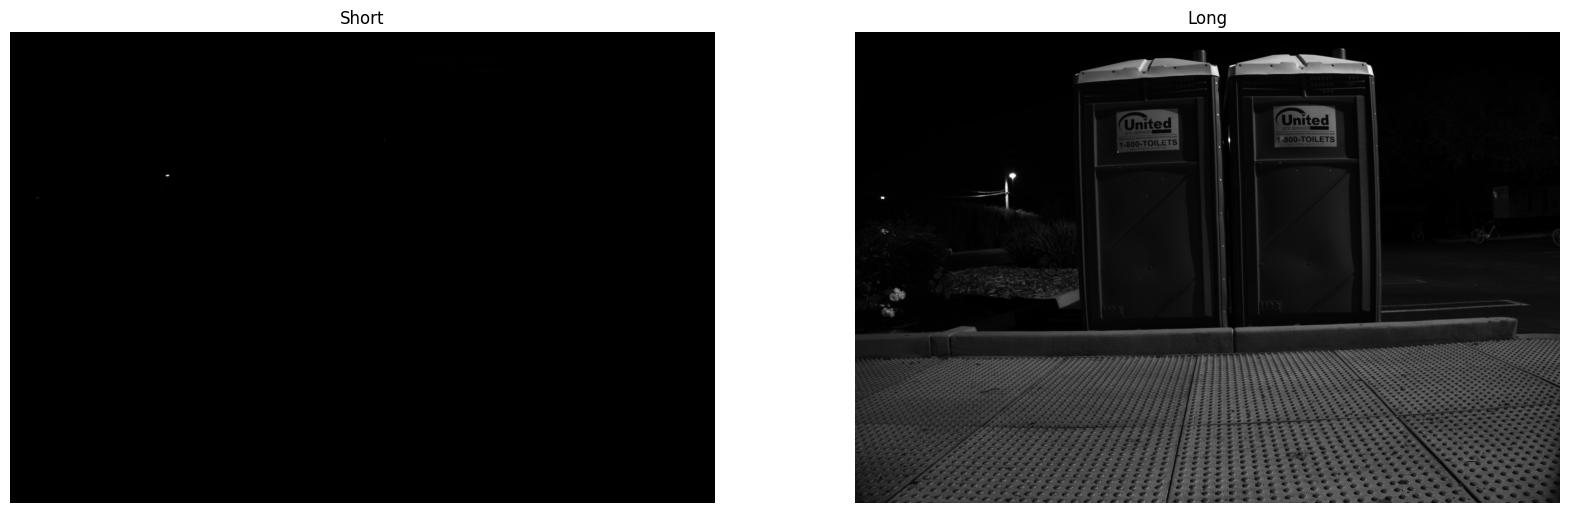

In [112]:
train_dataset.visualize_paired_raw_image(0)

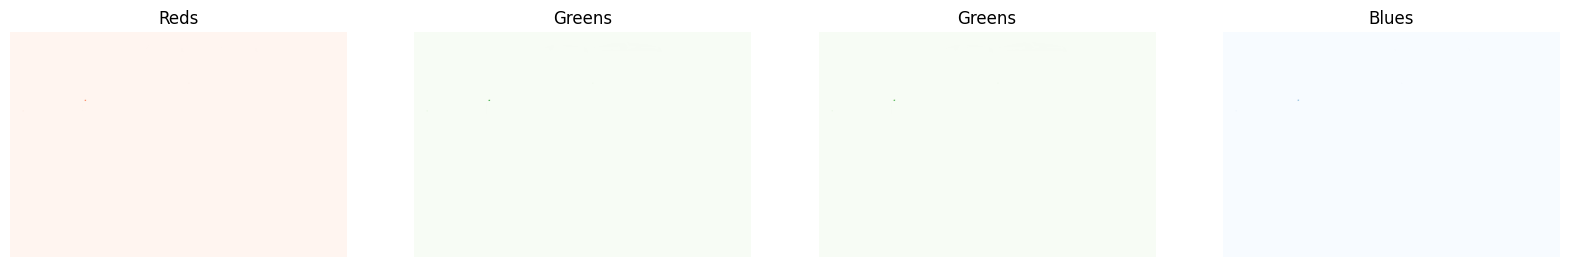

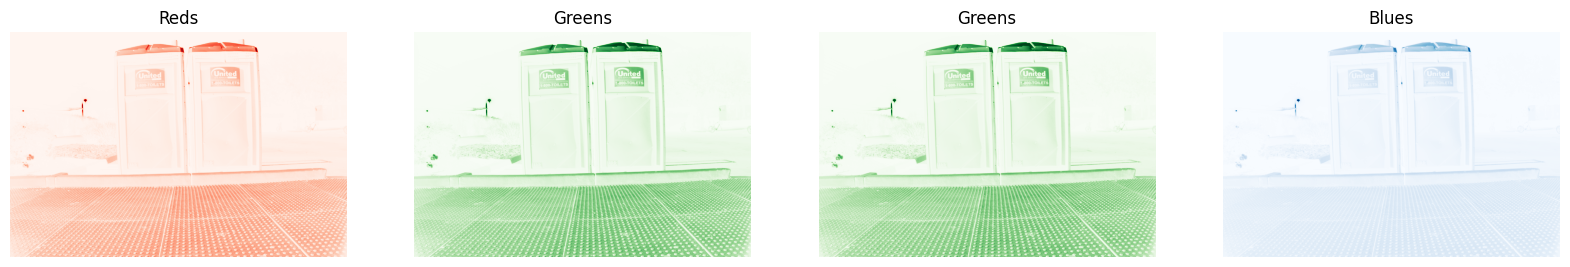

In [113]:
train_dataset.visualize_packed_image(0)

## Define the Model

In [ ]:
class SwinTransformerFeatureExtractor(SwinTransformer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mlp_head = nn.Identity()

    def forward(self, x):
        features = super().forward(x)
        return features

In [ ]:
class SwinIR(nn.Module):
    def __init__(self, input_channels=4, output_channels=3):
        super(SwinIR, self).__init__()

        # swim transformer encoder
        self.encoder = SwinTransformerFeatureExtractor(
            hidden_dim=96,
            layers=(2, 2, 6, 2),
            heads=(3, 6, 12, 24),
            channels=input_channels,
        )

        # decoder: upsampling
        self.up6 = nn.ConvTranspose2d(768, 384, kernel_size=2, stride=2)
        self.conv6 = self.conv2d_block(768, 384)

        self.up7 = nn.ConvTranspose2d(384, 192, kernel_size=2, stride=2)
        self.conv7 = self.conv2d_block(384, 192)

        self.up8 = nn.ConvTranspose2d(192, 96, kernel_size=2, stride=2)
        self.conv8 = self.conv2d_block(192, 96)

        self.up9 = nn.ConvTranspose2d(96, 48, kernel_size=2, stride=2)
        self.conv9 = self.conv2d_block(96, 48)

        # output
        self.conv10 = nn.Conv2d(48, 12, kernel_size=1, padding="same")
        self.pixel_shuffle = nn.PixelShuffle(2)
        
    def conv2d_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.2)
        )

    def forward(self, x):
        features = self.encoder(x)
        B, _, H, W = x.shape
        C = features.shape[1]
        
        print(f"Swin Transformer Output Shape (before reshape): {features.shape}")
    
        # manually reshape Swin's output to match expected spatial size
        # Swin downsamples by 32
        features = features.view(B, C, H // 32, W // 32)
    
        print(f"Reshaped Feature Map for Decoder: {features.shape}")

        up6 = self.up6(features)
        conv6 = self.conv6(up6)

        up7 = self.up7(conv6)
        conv7 = self.conv7(up7)

        up8 = self.up8(conv7)
        conv8 = self.conv8(up8)

        up9 = self.up9(conv8)
        conv9 = self.conv9(up9)

        conv10 = self.conv10(conv9)
        output = self.pixel_shuffle(conv10)

        return output

In [ ]:
model = SwinIR()

### Compile the Model

#### Charbonnier Loss

$L(x, y) = \sqrt{(x - y)^2 + \epsilon^2}$

In [ ]:
class CharbonnierLoss(nn.Module):
    def __init__(self, eps=1e-3):
        """
        charbonnier loss, smooth L1 loss
        """
        super(CharbonnierLoss, self).__init__()
        self.eps = eps

    def forward(self, y_pred, y_true):
        diff = y_true - y_pred
        loss = torch.mean(torch.sqrt(diff ** 2 + self.eps ** 2))
        return loss

#### SSIM Loss

$L(x, y) = 1 - SSIM(x, y)$

In [ ]:
class SSIMLoss(nn.Module):
    def __init__(self):
        """
        SSIM-based perceptual loss (1 - Structural Similarity)
        """
        super(SSIMLoss, self).__init__()
        
    def forward(self, y_pred, y_true):
        y_pred = F.interpolate(y_pred, size=y_true.shape[2:], mode="bilinear", align_corners=False)
        ssim_value = transforms.functional.ssim(y_pred, y_true, data_range=1.0)

        return 1 - ssim_value.mean()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)  # decay rate = 0.9
charbonnier = CharbonnierLoss()
ssim = SSIMLoss()

### Train the Model

In [ ]:
checkpoint_path = "/kaggle/working/swinIR.pth"

def save_checkpoint(model, optimizer, epoch, best_loss):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_loss': best_loss
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch}, val_loss: {best_loss:.6f}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Num GPUs Available: {torch.cuda.device_count()}")
model.to(device)

In [ ]:
def load_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_loss = checkpoint['best_loss']
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']}, best val_loss: {best_loss:.6f}")
    return best_loss

In [ ]:
EPOCHS = 1
BATCH_SIZE = 1

train_length = len(train_pairs)
val_length = len(val_pairs)

val_subsplits = 5
steps_per_epoch = train_length // BATCH_SIZE
validation_steps = val_length // BATCH_SIZE // val_subsplits

In [ ]:
for epoch in range(EPOCHS):
    model.train()
    total_train_charb_loss = 0.0
    total_train_ssim_loss = 0.0

    for batch_idx, (short_img, long_img) in enumerate(train_loader):
        short_img, long_img = short_img.to(device), long_img.to(device)

        optimizer.zero_grad()
        output = model(short_img)

        charb_loss = charbonnier(output, long_img)
        ssim_l = ssim(output, long_img)

        charb_loss.backward()
        optimizer.step()

        total_train_charb_loss += charb_loss.item()
        total_train_ssim_loss += ssim_l.item()

        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch {epoch+1}, Step {batch_idx+1}/{steps_per_epoch}, "
                  f"Charbonnier Loss: {charb_loss.item():.6f}, SSIM Loss: {ssim_l.item():.6f}")
